# Worksheet 12

Name:  Xavier Thomas
UID: U72282207

### Topics

- Introduction to Classification
- K Nearest Neighbors

### Introduction to Classification

a) For the following examples, say whether they are or aren't an example of classification.

1. Predicting whether a student will be offered a job after graduating given their GPA.
2. Predicting how long it will take (in number of months) for a student to be offered a job after graduating, given their GPA.
3. Predicting the number of stars (1-5) a person will assign in their yelp review given the description they wrote in the review.
4. Predicting the number of births occuring in a specified minute.

1. True
2. False
3. True
4. False

b) Given a dataset, how would you set things up such that you can both learn a model and get an idea of how this model might perform on data it has never seen?

Cross Validation

c) In your own words, briefly explain:

- underfitting
- overfitting

and what signs to look out for for each.

underfitting - when the model is too simple to capture the data, can be observed by poor training performance
overfitting - when the model is too complex and fits only the training data and does not work well for test data, can be observed by poor test performance.

### K Nearest Neighbors

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = {
    "Attribute A" : [3.5, 0, 1, 2.5, 2, 1.5, 2, 3.5, 1, 3, 2, 2, 2.5, 0.5, 0., 10],
    "Attribute B" : [4, 1.5, 2, 1, 3.5, 2.5, 1, 0, 3, 1.5, 4, 2, 2.5, 0.5, 2.5, 10],
    "Class" : [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0],
}

a) Plot the data in a 2D plot coloring each scatter point one of two colors depending on its corresponding class.

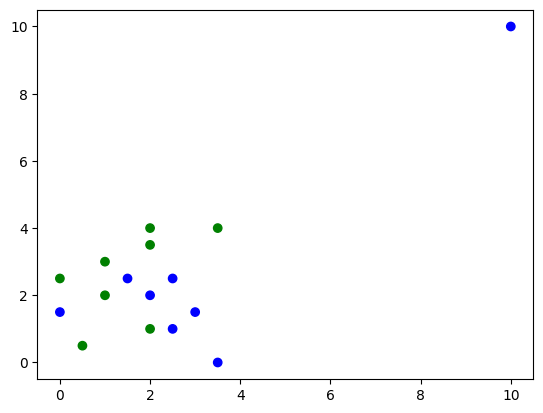

In [2]:
colors = np.array([x for x in 'bgrcmyk'])
plt.scatter(data["Attribute A"], data["Attribute B"], c=colors[data["Class"]], label=data["Class"])
plt.show()

Outliers are points that lie far from the rest of the data. They are not necessarily invalid points however. Imagine sampling from a Normal Distribution with mean 10 and variance 1. You would expect most points you sample to be in the range [7, 13] but it's entirely possible to see 20 which, on average, should be very far from the rest of the points in the sample (unless we're VERY (un)lucky). These outliers can inhibit our ability to learn general patterns in the data since they are not representative of likely outcomes. They can still be useful in of themselves and can be analyzed in great depth depending on the problem at hand.

b) Are there any points in the dataset that could be outliers? If so, please remove them from the dataset.

Yes, the point at (10, 10) is an outlier and needs to be removed

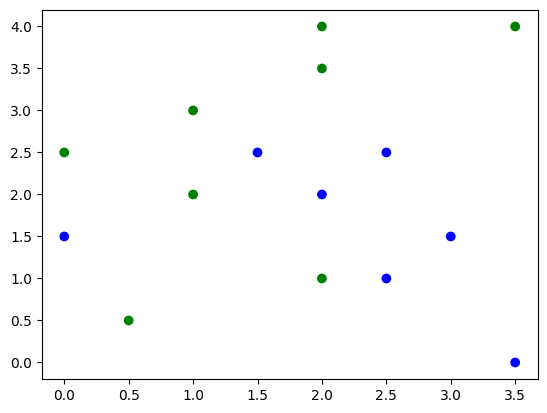

In [3]:
from scipy import stats
z_scores_a = np.abs(stats.zscore(data["Attribute A"]))
z_scores_b = np.abs(stats.zscore(data["Attribute B"]))
z_score_threshold = 2
outlier_indices = np.where((z_scores_a > z_score_threshold) | (z_scores_b > z_score_threshold))[0]

for key in data:
    data[key] = [data[key][i] for i in range(len(data[key])) if i not in outlier_indices]

colors = np.array([x for x in 'bgrcmyk'])
plt.scatter(data["Attribute A"], data["Attribute B"], c=colors[data["Class"]], label=data["Class"])
plt.show()

Noise points are points that could be considered invalid under the general trend in the data. These could be the result of actual errors in the data or randomness that we could attribute to oversimplification (for example if missing some information / feature about each point). Considering noise points in our model can often lead to overfitting.

c) Are there any points in the dataset that could be noise points?

Yes the green points below the blue points could be noise points

For the following point

|  A  |  B  |
|-----|-----|
| 0.5 |  1  |

d) Plot it in a different color along with the rest of the points in the dataset.

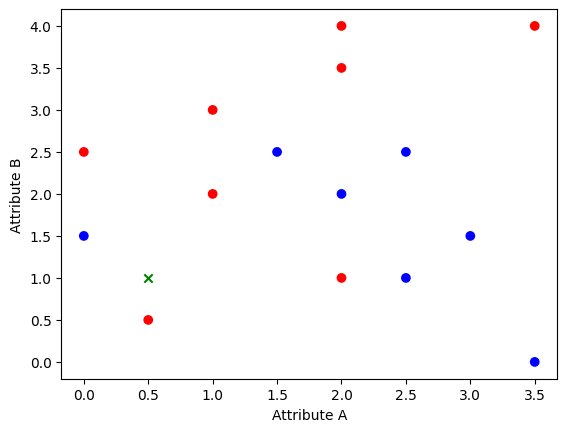

In [4]:
colors = np.array(['b', 'r'])  
plt.scatter(data["Attribute A"], data["Attribute B"], c=colors[data["Class"]], label=data["Class"])
plt.scatter(0.5, 1, c='g', marker='x', label='New Point')
plt.xlabel("Attribute A")
plt.ylabel("Attribute B")
plt.show()

e) Write a function to compute the Euclidean distance from it to all points in the dataset and pick the 3 closest points to it. In a scatter plot, draw a circle centered around the point with radius the distance of the farthest of the three points.

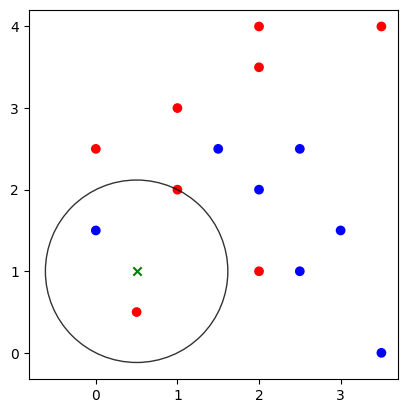

In [5]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def n_closest_to(example, n, dataset):
    distances = [euclidean_distance(example, point) for point in dataset]
    sorted_indices = np.argsort(distances)
    n_closest_indices = sorted_indices[:n]
    n_closest_points = [dataset[i] for i in n_closest_indices]
    farthest_distance = distances[n_closest_indices[-1]]
    return n_closest_points, farthest_distance



location = (0.5, 1)
dataset = list(zip(data["Attribute A"], data["Attribute B"]))
n = 3
closest_points, radius = n_closest_to(location, n, dataset)
_, axes = plt.subplots()
colors = np.array(['b', 'r'])
axes.scatter(data["Attribute A"], data["Attribute B"], c=colors[data["Class"]], label=data["Class"])
plt.scatter(0.5, 1, c='g', marker='x', label='New Point')
cir = plt.Circle(location, radius, fill = False, alpha=0.8)
axes.add_patch(cir)
axes.set_aspect('equal') # necessary so that the circle is not oval
plt.show()

f) Write a function that takes the three points returned by your function in e) and returns the class that the majority of points have (break ties with a deterministic default class of your choosing). Print the class assigned to this new point by your function.

In [6]:
closest_points

[(0.5, 0.5), (0, 1.5), (1, 2)]

In [7]:
def majority(points):
    class_counts = {0: 0, 1: 0} 
    for point in closest_points:
        class_counts[data["Class"][data["Attribute A"].index(point[0])]] += 1
    if class_counts[0] > class_counts[1]:
        return 0 
    else:
        return 1 

resulting_class = majority(closest_points)
print("Majority Class:", resulting_class)

Majority Class: 1


g) Re-using the functions from e) and f), you should be able to assign a class to any new point. In this exercise we will implement Leave-one-out cross validiation in order to evaluate the performance of our model.

For each point in the dataset:

- consider that point as your test set and the rest of the data as your training set
- classify that point using the training set
- keep track of whether you were correct with the use of a counter

Once you've iterated through the entire dataset, divide the counter by the number of points in the dataset to report an overall testing accuracy.

In [8]:
count = 0
for i in range(len(data["Attribute A"])):
    actual_class = data["Class"][i]
    training_set =  [(data["Attribute A"][j], data["Attribute B"][j]) for j in range(len(data["Attribute A"])) if j != i]
    closest_points, radius = n_closest_to((data["Attribute A"][i], data["Attribute B"][i]), 3, training_set)
    prediction = majority(closest_points)
    if prediction == actual_class:
        count += 1

overall_accuracy = count / len(data["Attribute A"])

print("Overall accuracy =", overall_accuracy)

Overall accuracy = 0.6
